In [1]:
# since this refactoring is designed to produce differentiable transformations
# we might want to take advantage of that
using Flux

┌ Warning: This version of CUDA.jl only supports NVIDIA drivers for CUDA 10.1 or higher (yours is for CUDA 9.1.0)
└ @ CUDA C:\Users\Fluid3\.julia\packages\CUDA\M4jkK\src\initialization.jl:100


In [2]:
import TestImages: testimage
import ImageView: imshow

img = testimage("mandrill")
(xsize, ysize) = size(img)

(512, 512)

In [3]:
function warp3(x, y, p) # 0:31
    knob = p[:knob]
    clip(n, nsize) = max(min(nsize, n), 1)
    (xnew, ynew) =
        # clip(convert(Int, floor(x - 10 * (knob / 32) * sin(y/4))), xsize), y), # currently unused variant
        # clip(convert(Int, floor(x + 10 * ((knob - 16) / 16) * sin(y/4))), xsize), y) # normalize to get +/-
        (clip(x + 10 * ((knob - 16) / 16) * sin(y/4), xsize), y)
    xnew, ynew
end

warp3 (generic function with 1 method)

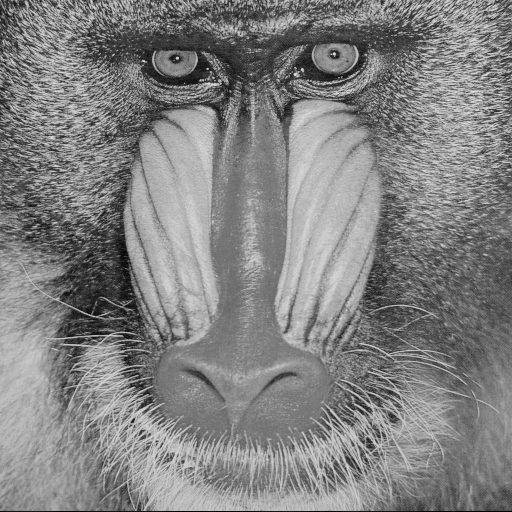

In [4]:
import Images: Gray
img_gray = 1*Gray.(img)

In [5]:
function apply_warp(warp, im, p)
    (xsize, ysize) = size(im)
    p[:xsize] = xsize
    p[:ysize] = ysize
    function linear_interpolation(x_y)
        # a rough draft, this can be improved; works on im
        x = x_y[1]
        y = x_y[2]
        dx=mod(x,1)
        dy=mod(y,1)
        x_left = floor(Int,x)
        y_left = floor(Int,y)
        x_right = min(x_left + 1, xsize)
        y_right = min(y_left + 1, ysize)
        im[x_left,y_left]*(1-dx)*(1-dy) + im[x_left,y_right]*(1-dx)*dy + im[x_right,y_left]*dx*(1-dy) + im[x_right, y_right]*dx*dy
    end
    [linear_interpolation(warp(x,y,p)) for x in 1:xsize, y in 1:ysize]
end

apply_warp (generic function with 1 method)

In [8]:
pars = Dict(:knob=>0, :dummy=>0.0)
# at least one of the above should be float and not integer, so that the dictionary type is
# Dict{Symbol, Real}  and not Dict{Symbol, Int64}

Dict{Symbol, Real} with 2 entries:
  :dummy => 0.0
  :knob  => 0

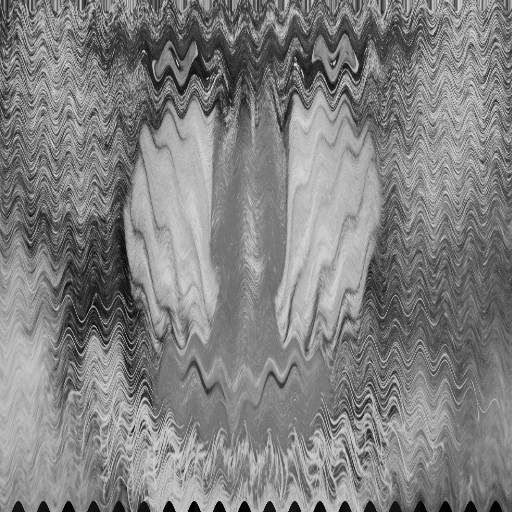

In [9]:
im3 = apply_warp(warp3, img_gray, pars)

In [10]:
# scale image so that all points brightness are between 0 and 1, and that full range is used
function normalize_image(im)
    im_res = im - minimum(im)
    return (1/maximum(im_res))*im_res
end

normalize_image (generic function with 1 method)

In [11]:
import LinearAlgebra: transpose

In [12]:
norm_columns(f, x) = f.(x) ./ (sum(f.(x), dims=1))

norm_columns (generic function with 1 method)

In [13]:
norm_rows(f, x) = transpose(norm_columns(f, transpose(x)))

norm_rows (generic function with 1 method)

In [14]:
norm_image_columns(f, x) = normalize_image(Gray.(norm_columns(f, x)))

norm_image_columns (generic function with 1 method)

In [15]:
norm_image_rows(f, x) = normalize_image(Gray.(norm_rows(f, x)))

norm_image_rows (generic function with 1 method)

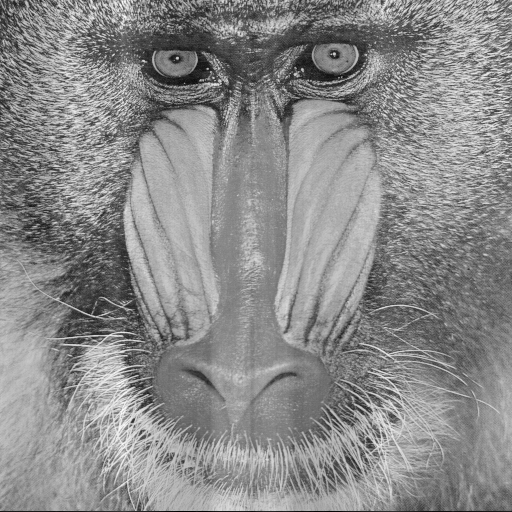

In [16]:
start_at_one_img = norm_image_columns(x -> x+1, img_gray)

In [17]:
transposed_product(x) = normalize_image(transpose(x)*x)

transposed_product (generic function with 1 method)

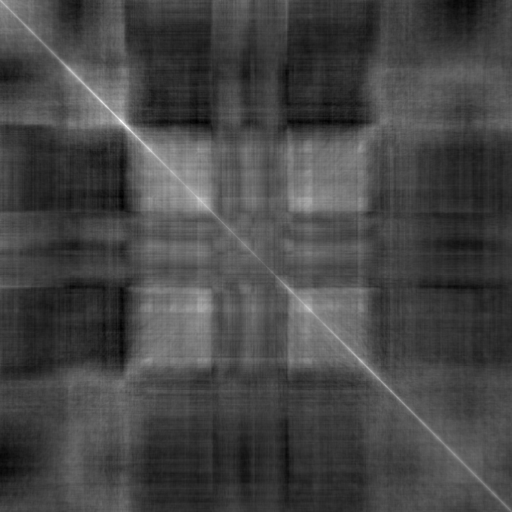

In [18]:
p_with_start_at_one = transposed_product(start_at_one_img)

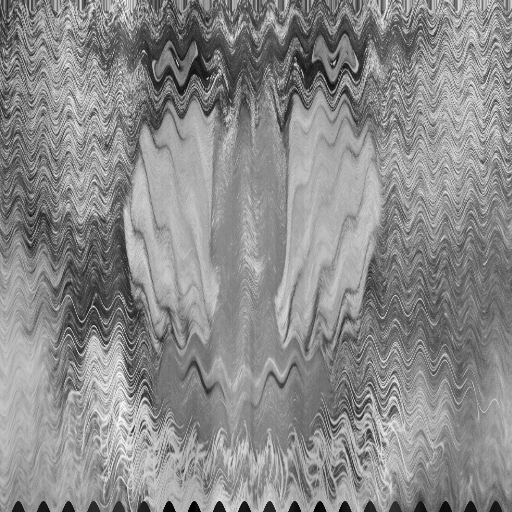

In [19]:
start_at_one_im3 = norm_image_columns(x -> x+1, im3)

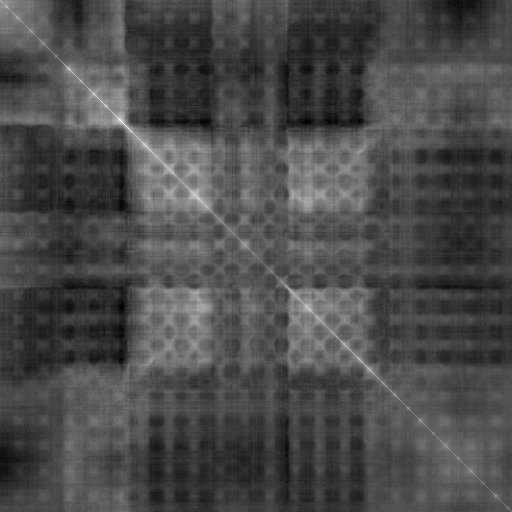

In [20]:
p_with_start_at_one_im3 = transposed_product(start_at_one_im3)

In [21]:
variation3(warp, im, p) = transposed_product(norm_image_columns(x -> x+1, apply_warp(warp, im, p)))

variation3 (generic function with 1 method)

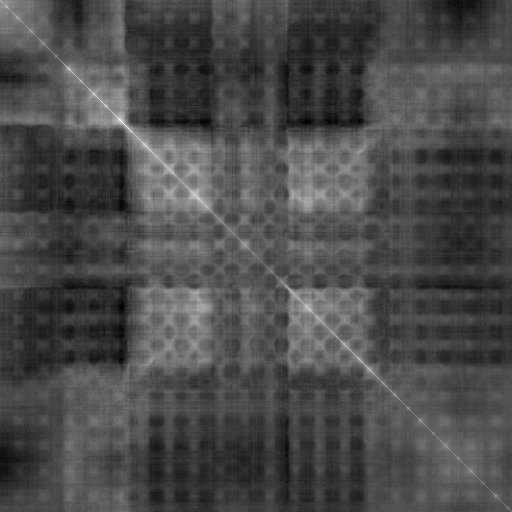

In [22]:
variation3(warp3, img_gray, pars)

In [23]:
# yes, with x->x+1 instead of exp, this is a bit crisper than softmax
# in https://nbviewer.jupyter.org/github/anhinga/julia-notebooks/blob/main/grimoire-team/variations/variation-4.ipynb
# So, this is indeed better

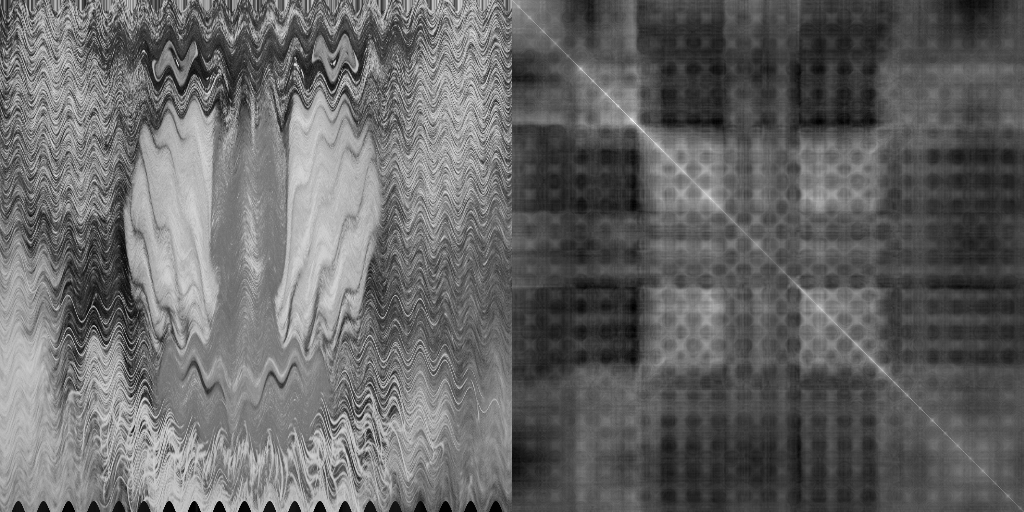

In [24]:
hcat(im3, p_with_start_at_one_im3)

In [25]:
function result3(warp, im, p)
    im3 = apply_warp(warp, im, p)
    product3 = transposed_product(norm_image_columns(x -> x+1, im3))
    hcat(im3, product3)
end

result3 (generic function with 1 method)

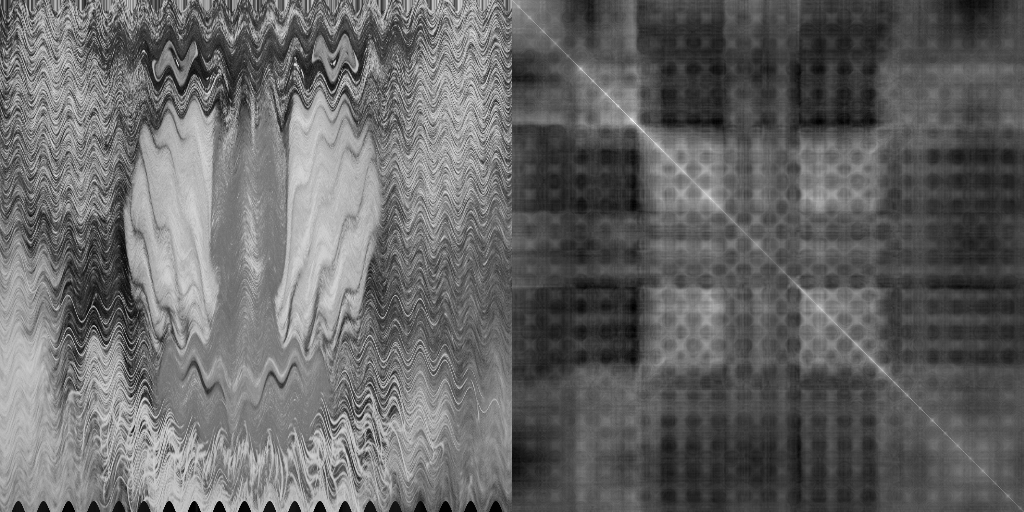

In [26]:
result3(warp3, img_gray, pars)

In [27]:
pars

Dict{Symbol, Real} with 4 entries:
  :ysize => 512
  :dummy => 0.0
  :knob  => 0
  :xsize => 512

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

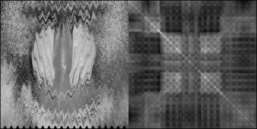
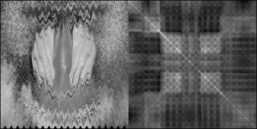
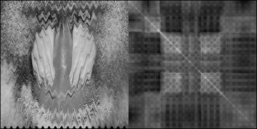
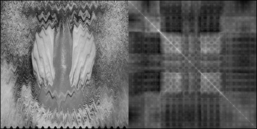
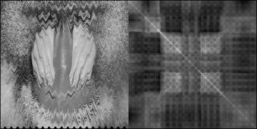
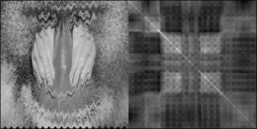
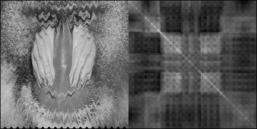
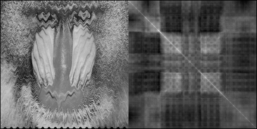
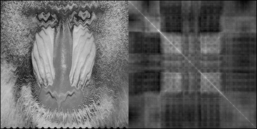
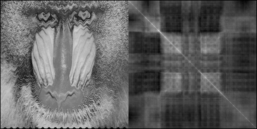
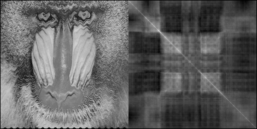
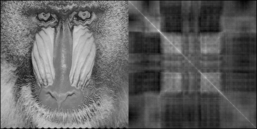
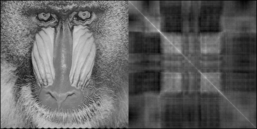
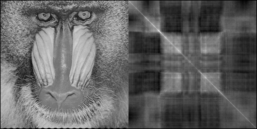
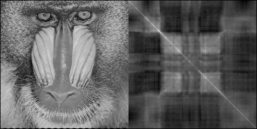
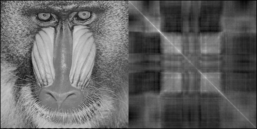
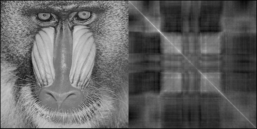
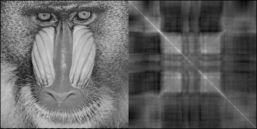
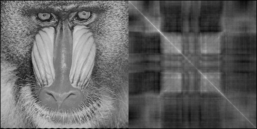
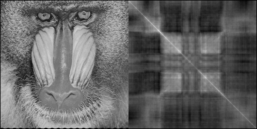
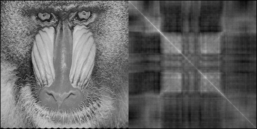
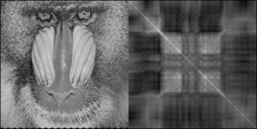
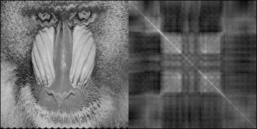
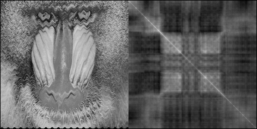
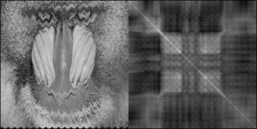
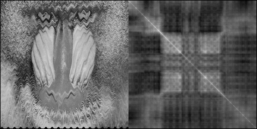
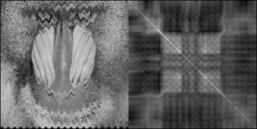
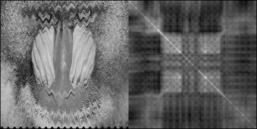
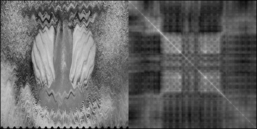
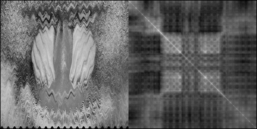
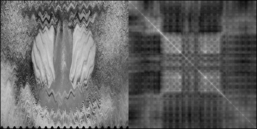
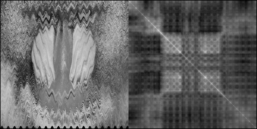

In [28]:
imgs3 = [result3(warp3, img_gray, pars) for pars[:knob] in 0:31]

In [29]:
zsize = length(imgs3)

32

In [30]:
using FileIO

full_imgs3 = []
for i in 1:zsize
    push!(full_imgs3, imgs3[i])
end
for i in reverse(2:(zsize-1))
    push!(full_imgs3, imgs3[i])
end

save("variations-fps60.gif", cat(full_imgs3..., dims=3), fps=60)

In [31]:
# there is a bit of flickering in the resulting product
# whether one uses fps=30 or fps=2 or anything in between
# there might be some discomfort 
# (it's easy to reproduce the animation, if one wants to analize the pattern,
# but I am not releasing the file due to the potential discomfort issue)

# alternatively, one might ponder a flicker reduction normalization here

# it's reasonably tolerable at fps=60, so I might release that

In [32]:
pars

Dict{Symbol, Real} with 4 entries:
  :ysize => 512
  :dummy => 0.0
  :knob  => 31
  :xsize => 512

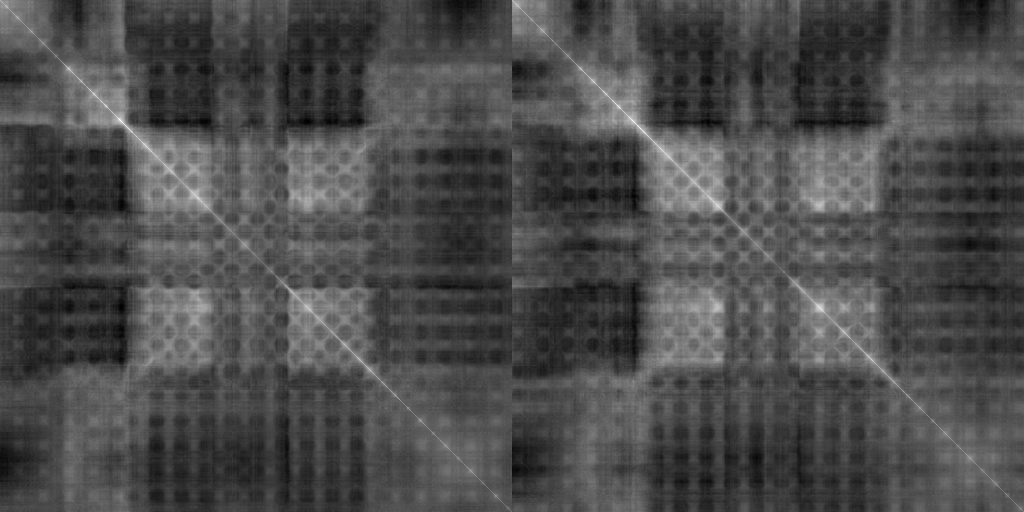

In [33]:
hcat(p_with_start_at_one_im3, variation3(warp3, img_gray, pars))

In [34]:
# the above are the results at different ends of our range - it would be interesting to analyze differences better

In [35]:
# Now, we have a nice set-up for Flux exercises

In [36]:
value3(A) = transposed_product(norm_image_columns(x -> x+1, A))

value3 (generic function with 1 method)

In [37]:
import LinearAlgebra: norm

In [38]:
loss(x, y) = norm(value3(x) - y)

loss (generic function with 1 method)

In [ ]:
# This does not explicitly break, but is taking forever
# The next step is to figure out the configuration, where an equivalent of this works
grads = gradient(() -> loss(img_gray, p_with_start_at_one_im3), params(img_gray))